In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from collections import defaultdict
from Solver import solver
import utilities as util

# Lectura de Datos

In [2]:
df = pd.read_csv("datos_arreglados.csv", encoding="latin1")
df = df[df["ID"] > 60]

In [3]:
#df.rename(columns={'Ethical technology assessment?':'Ethical technology assessment'}, inplace=True)

bach = df[df['program'] == 'bachelor'] #selecciona las tuplas de bachelor en un df
mast = df[df['program'] == 'master'] #selecciona las tuplas master en un df

b_aal = bach[bach['campus'] == 'AAL'] #selecciona las tuplas bachelor aal en df
m_aal = mast[mast['campus'] == 'AAL'] #selecciona las tuplas master aal en df

b_cph = bach[bach['campus'] == 'CPH'] #selecciona las tuplas bachelor cph en df
m_cph = mast[mast['campus'] == 'CPH'] #selecciona las tuplas master cph en df

esb = df[df['campus'] == 'ESB'] #selecciona las tuplas esb en df

In [4]:
col1 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most4' 
col2 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most5'
col3 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most6'

cursos_b_aal = list(set(b_aal[col1]) | set(b_aal[col2]) | set(b_aal[col3])) #talleres disponibles para bachelor aal, en base a los seleccionados en top 3
cursos_m_aal = list(set(m_aal[col1]) | set(m_aal[col2]) | set(m_aal[col3])) #talleres disponibles para master aal,  en base a los seleccionados en top 3

cursos_b_cph = list(set(b_cph[col1]) | set(b_cph[col2]) | set(b_cph[col3])) #talleres disponibles para bachelor cph, en base a los seleccionados en top 3
cursos_m_cph = list(set(m_cph[col1]) | set(m_cph[col2]) | set(m_cph[col3])) #talleres disponibles para master cph,  en base a los seleccionados en top 3

cursos_esb = list(set(esb[col1]) | set(esb[col2]) | set(esb[col3])) #talleres disponibles para esb, en base a los seleccionados en top 3


#selecciona columnas de los nombres de curso, donde cada columna posee NaN, 1, 2, 3 indicando preferencia top 3 o no
pref_b_aal = b_aal[cursos_b_aal] 
pref_m_aal = m_aal[cursos_m_aal] 

pref_b_cph = b_cph[cursos_b_cph]
pref_m_cph = m_cph[cursos_m_cph]

pref_esb = esb[cursos_esb]

Establecer preferencias de estudiantes

In [5]:
def generate_col_nums(data):
    ans = {}
    c = 0
    for col in data.columns:
        ans[col] = c
        c += 1
    return ans

def get_dict(data, row):
    ans = {}
    # PROVISOR #
    ans[1] = 0
    ans[2] = 0
    ans[3] = 0
    names = generate_col_nums(data)           #asocia a cada taller un id 0, 1, ...
    for col in data.columns:
        if not np.isnan(data.iloc[row][col]): #si no es Nan, es decir, si está en su top 3
            ans[int(data.iloc[row][col])] = names[col]
    return ans


In [6]:
#ejemplo:
get_dict(pref_m_aal, 1)                     # Para saber preferencia de estudiante 
                                            # s en opcion i. se aplica t_pref[s][i]
                                            # OJO: Las columnas se aleatorizan en cada kernel

{1: 4, 2: 0, 3: 2}

# Implementación

In [7]:
# La idea es correr esta función y cambiar lo necesario despues de correrla
def get_par(pref):

    # --- Dimensiones ---
    n_students  = len(pref)        # number of students in master AAL
    n_workshops = pref.shape[1]    # number of workshops in master AAL

    S = [n for n in range(n_students)]   # numera a los estudiantes
    T = [n for n in range(n_workshops)]  # numera a los talleres

    # --- Horarios ---
    H = [0, 1]                           # AM (0) o PM (1)
                                        # Revisar siempre que sea válido, es decir, que el total de vacantes
                                        # para la mañana y la tarde sea >= que la cantidad de estudiantes.

    # --- Capacidades ---
    C = [3, 3]                           # capacidad de talleres por horario (AM, PM)
    U = [30 for _ in range(n_workshops)]# capacidad de cada taller (todos con 150 cupos)

    # --- Preferencias ---
    t_pref = [
        get_dict(pref, n)          # obtiene preferencias top 3 para cada estudiante
        for n in range(n_students)
    ]

    # --- Duración de talleres ---
    D = [0 for _ in range(n_workshops)]  # 1 si el taller es de día completo, 0 si no
    D[4] = 1                             # el taller 4 es de día completo

    # --- Pesos ---
    p = [10, 5, 3]                       # pesos para cada preferencia

    return (S, T, H, C, U, t_pref, D, p)

In [8]:
(S, T, H, C, U, t_pref, D, p) = get_par(pref_m_cph)

In [9]:
modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)

Set parameter Username
Set parameter LicenseID to value 2674724
Academic license - for non-commercial use only - expires 2026-06-03
Set parameter TimeLimit to value 1800


In [10]:
#si falla ver la razón
"""
if model.status == GRB.INFEASIBLE:
    print("Modelo es infeasible. Buscando IIS...")
    
    # Computar IIS
    model.computeIIS()
    
    # Mostrar restricciones y variables en conflicto
    print("\nRestricciones en conflicto:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(c.ConstrName)
    
    print("\nVariables involucradas en conflicto:")
    for v in model.getVars():
        if v.IISLB or v.IISUB:
            print(v.VarName)
"""

'\nif model.status == GRB.INFEASIBLE:\n    print("Modelo es infeasible. Buscando IIS...")\n\n    # Computar IIS\n    model.computeIIS()\n\n    # Mostrar restricciones y variables en conflicto\n    print("\nRestricciones en conflicto:")\n    for c in model.getConstrs():\n        if c.IISConstr:\n            print(c.ConstrName)\n\n    print("\nVariables involucradas en conflicto:")\n    for v in model.getVars():\n        if v.IISLB or v.IISUB:\n            print(v.VarName)\n'

# Resultados

In [11]:
util.ver_talleres(z)

El taller 0 no se realizará
El taller 1 fue elegido para realizarse
El taller 2 no se realizará
El taller 3 fue elegido para realizarse
El taller 4 fue elegido para realizarse
El taller 5 no se realizará
El taller 6 fue elegido para realizarse
El taller 7 fue elegido para realizarse


In [12]:
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 1 se da en el horario AM
El taller 3 se da en el horario AM
El taller 4 se da en el horario AM
El taller 4 se da en el horario PM
El taller 6 se da en el horario PM
El taller 7 se da en el horario PM


In [13]:
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 1
El estudiante 0 fue asignado al taller 7
El estudiante 1 fue asignado al taller 1
El estudiante 1 fue asignado al taller 7
El estudiante 2 fue asignado al taller 1
El estudiante 2 fue asignado al taller 6
El estudiante 3 fue asignado al taller 1
El estudiante 3 fue asignado al taller 7
El estudiante 4 fue asignado al taller 3
El estudiante 4 fue asignado al taller 6
El estudiante 5 fue asignado al taller 1
El estudiante 5 fue asignado al taller 7
El estudiante 6 fue asignado al taller 1
El estudiante 6 fue asignado al taller 6
El estudiante 7 fue asignado al taller 3
El estudiante 7 fue asignado al taller 6
El estudiante 8 fue asignado al taller 1
El estudiante 8 fue asignado al taller 7
El estudiante 9 fue asignado al taller 3
El estudiante 9 fue asignado al taller 7
El estudiante 10 fue asignado al taller 3
El estudiante 10 fue asignado al taller 6
El estudiante 11 fue asignado al taller 3
El estudiante 11 fue asignado al taller 7
El estudiant

## Resultados

In [14]:
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [1, 7], 1: [1, 7], 2: [1, 6], 3: [1, 7], 4: [3, 6], 5: [1, 7], 6: [1, 6], 7: [3, 6], 8: [1, 7], 9: [3, 7], 10: [3, 6], 11: [3, 7], 12: [1, 7], 13: [4], 14: [3, 6], 15: [3, 7], 16: [1, 6], 17: [3, 6], 18: [3, 6], 19: [3, 7], 20: [1, 7], 21: [3, 7], 22: [1, 6], 23: [1, 6], 24: [1, 6], 25: [3, 6], 26: [4], 27: [3, 6], 28: [1, 7], 29: [4], 30: [1, 6], 31: [1, 7], 32: [3, 7], 33: [3, 7], 34: [4], 35: [3, 7], 36: [3, 7], 37: [4], 38: [3, 6], 39: [4], 40: [1, 7], 41: [4], 42: [4], 43: [1, 7], 44: [1, 7], 45: [4], 46: [1, 7], 47: [1, 7], 48: [4], 49: [1, 7], 50: [4], 51: [1, 7], 52: [4], 53: [4], 54: [4], 55: [3, 7], 56: [3, 7], 57: [1, 7], 58: [1, 7]}


In [15]:
for key, value in dic_asignaciones_realizadas.items():
    if len(value) != 2:
        print(f"Al estudiante {key} se le asignó taller(es) {value}, verificar si es taller de 1 día completo o fallo")

Al estudiante 13 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 26 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 29 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 34 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 37 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 39 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 41 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 42 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 45 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 48 se le asignó taller(es) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 50 se le asignó taller(es) [4], veri

In [16]:
#contar cuanto se llenó cada taller
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in capacidad_real_taller.items():
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U[taller])}% lleno")

El taller 1 tiene 25 alumnos, está un 83.33333333333334% lleno
El taller 7 tiene 29 alumnos, está un 96.66666666666667% lleno
El taller 6 tiene 16 alumnos, está un 53.333333333333336% lleno
El taller 3 tiene 20 alumnos, está un 66.66666666666666% lleno
El taller 4 tiene 14 alumnos, está un 46.666666666666664% lleno


In [17]:
suma_AM = 0
suma_PM = 0
for taller in talleres_AM:
    suma_AM += capacidad_real_taller[taller]
for taller in talleres_PM:
    suma_PM += capacidad_real_taller[taller]
print(suma_AM)
print(suma_PM)

59
59


### Visualizar algunas asignaciones de talleres vs lo que eligió

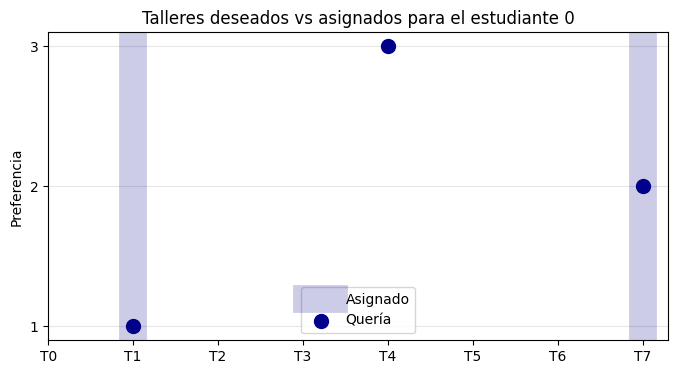

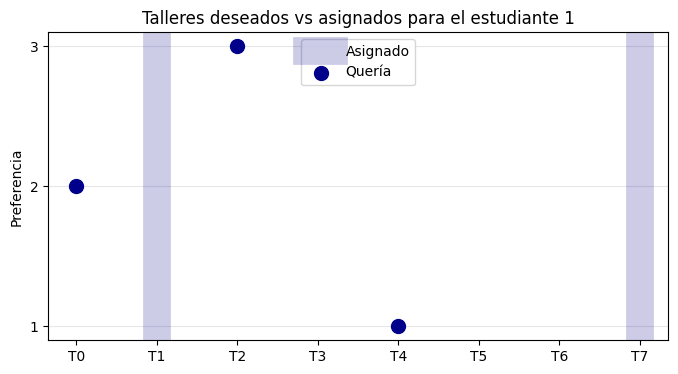

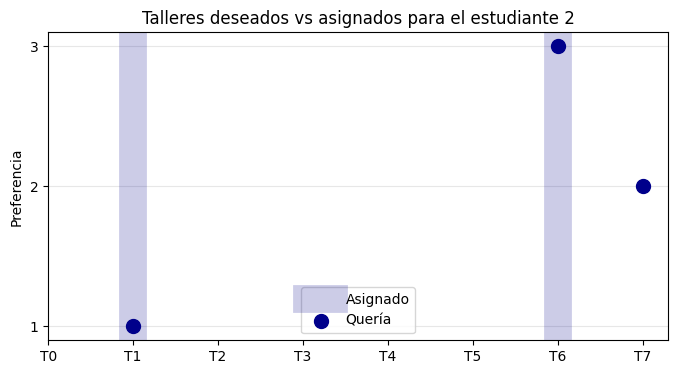

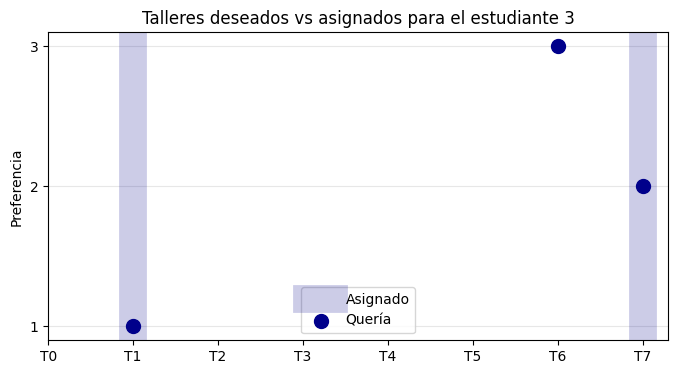

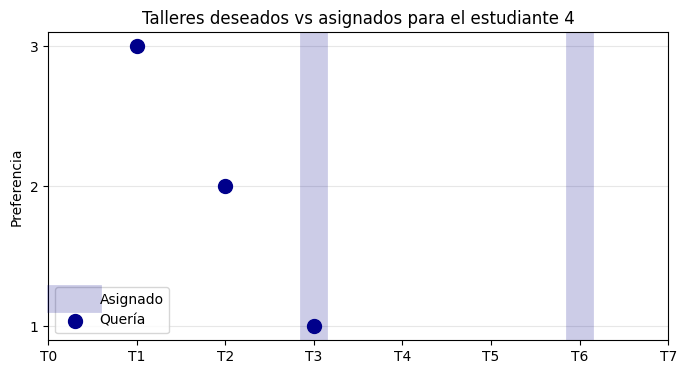

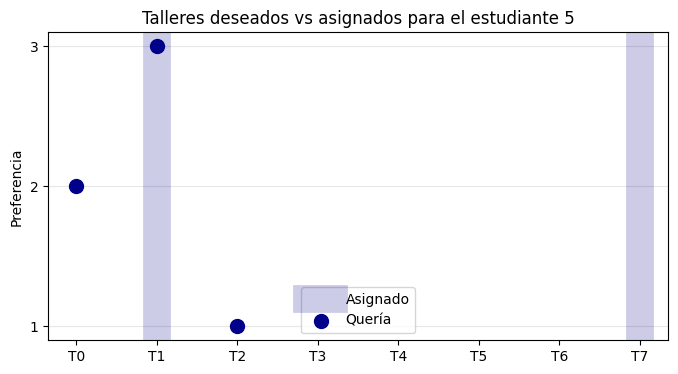

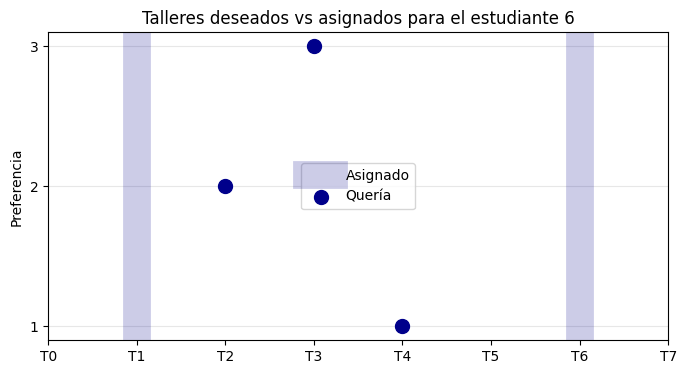

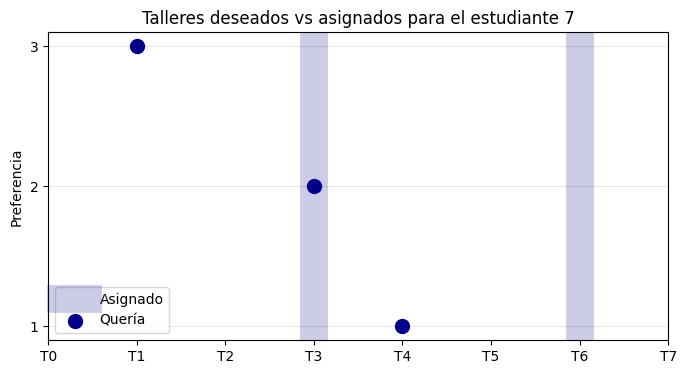

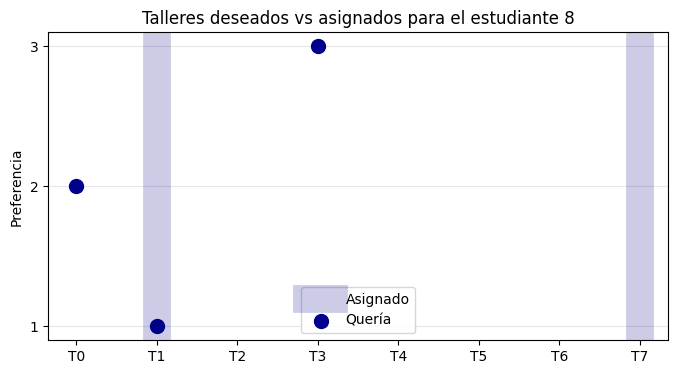

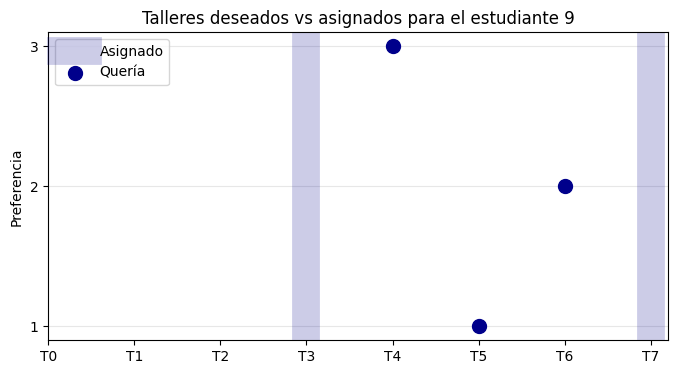

In [18]:
#visualizar la asignación de talleres
talleres = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
#para los estudiantes 0 al 9 muestra los talleres que quería y a los que fue asignado
for i in range(10):
    n_estudiante = i
    preferencias = get_dict(pref_m_aal, n_estudiante) #preferencia, taller
    asignados = dic_asignaciones_realizadas[i] #asignaciones que se les dio
    
    plt.figure(figsize=(8, 4))
    #sombrear las columnas de los talleres asignados
    for t in asignados:
        plt.axvline(x=t, color='darkblue', alpha=0.2, linewidth=20, label='Asignado' if t == asignados[0] else "")
    
    #marcar los puntos de las preferencias
    for pref, t in preferencias.items():
        plt.scatter(t, pref, color='darkblue', s=100, zorder=3, label='Quería' if pref == 1 else "")
    
    plt.xticks(range(len(talleres)), talleres)
    plt.yticks(range(1, 4))
    plt.ylabel('Preferencia')
    plt.title(f'Talleres deseados vs asignados para el estudiante {i}')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

# Estudiar por orden de llegada

Aca primero necesitaríamos alguna forma de seleccionar los talleres que se harían:

1. Hacer talleres con mayoría.
2. Probar combinaciones y elegir mejor: Hay 1575 formas de asignar

In [12]:
talleres_AM_realizar = [0, 1, 2, 3] 
talleres_PM_realizar = [4, 5, 6, 7] 

In [14]:
asignaciones = [[] for i in range(10)]

In [ ]:
def asignar(estudiante, asign, t_AM, t_PM):
    pref_1 = t_pref[estudiante][1]
    pref_1 = t_pref[estudiante][2]
    pref_1 = t_pref[estudiante][3]

In [ ]:
for j in S:
    

In [15]:
t_pref[0][1]

2